## Experiment 3: Faraday Cup Efficiency
This experiment looks at how the length and radius of the Faraday cup influence its particle retention.

In [41]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import libem
import numpy as np
from libvis import Visualizations, VideoMaker
import matplotlib.pyplot as plt

from components import *

from scipy.optimize import differential_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**General Configuration**

In [34]:
def generate_cup_space(cup_radius, cup_length, thickness=0.05, scale=30):
    sim = libem.EMSimulationSpace3D(space_size=(4, 2, 2), top_left=(-2, -1, -1), scale=scale)
    disk_mask = EMObjectMasks.closed_cylinder_in_plane(sim, (-1.9, 0, 0), cup_radius, thickness, 0, 1)
    cyl_mask = EMObjectMasks.open_cylinder_in_plane(sim, (-1.9, 0, 0), cup_radius, thickness / 2, cup_length, 0, 1)
    sim.compute(make_enforcer(
        enf(EMObjects.arbitrary_mask, disk_mask, 0),
        enf(EMObjects.arbitrary_mask, cyl_mask, 0)
    ), transient_ignore=1)
    sim.get_efield()
    return sim

NPARTICLES = 10
THICKNESS = 0.1
SCALE = 50

particle_opts = {
    "mass": (1, 0.25),
    "charge": (1, 0.25),
    "initial_loc": ((1.9, 0, 0), (0, 0, 0)),
    "initial_v": ((-1, 0, 0), (0.2, 0.05, 0.05)),
    "bounce_coef": 1
}

**Minimization of Escaped Particles**

<IPython.core.display.Javascript object>


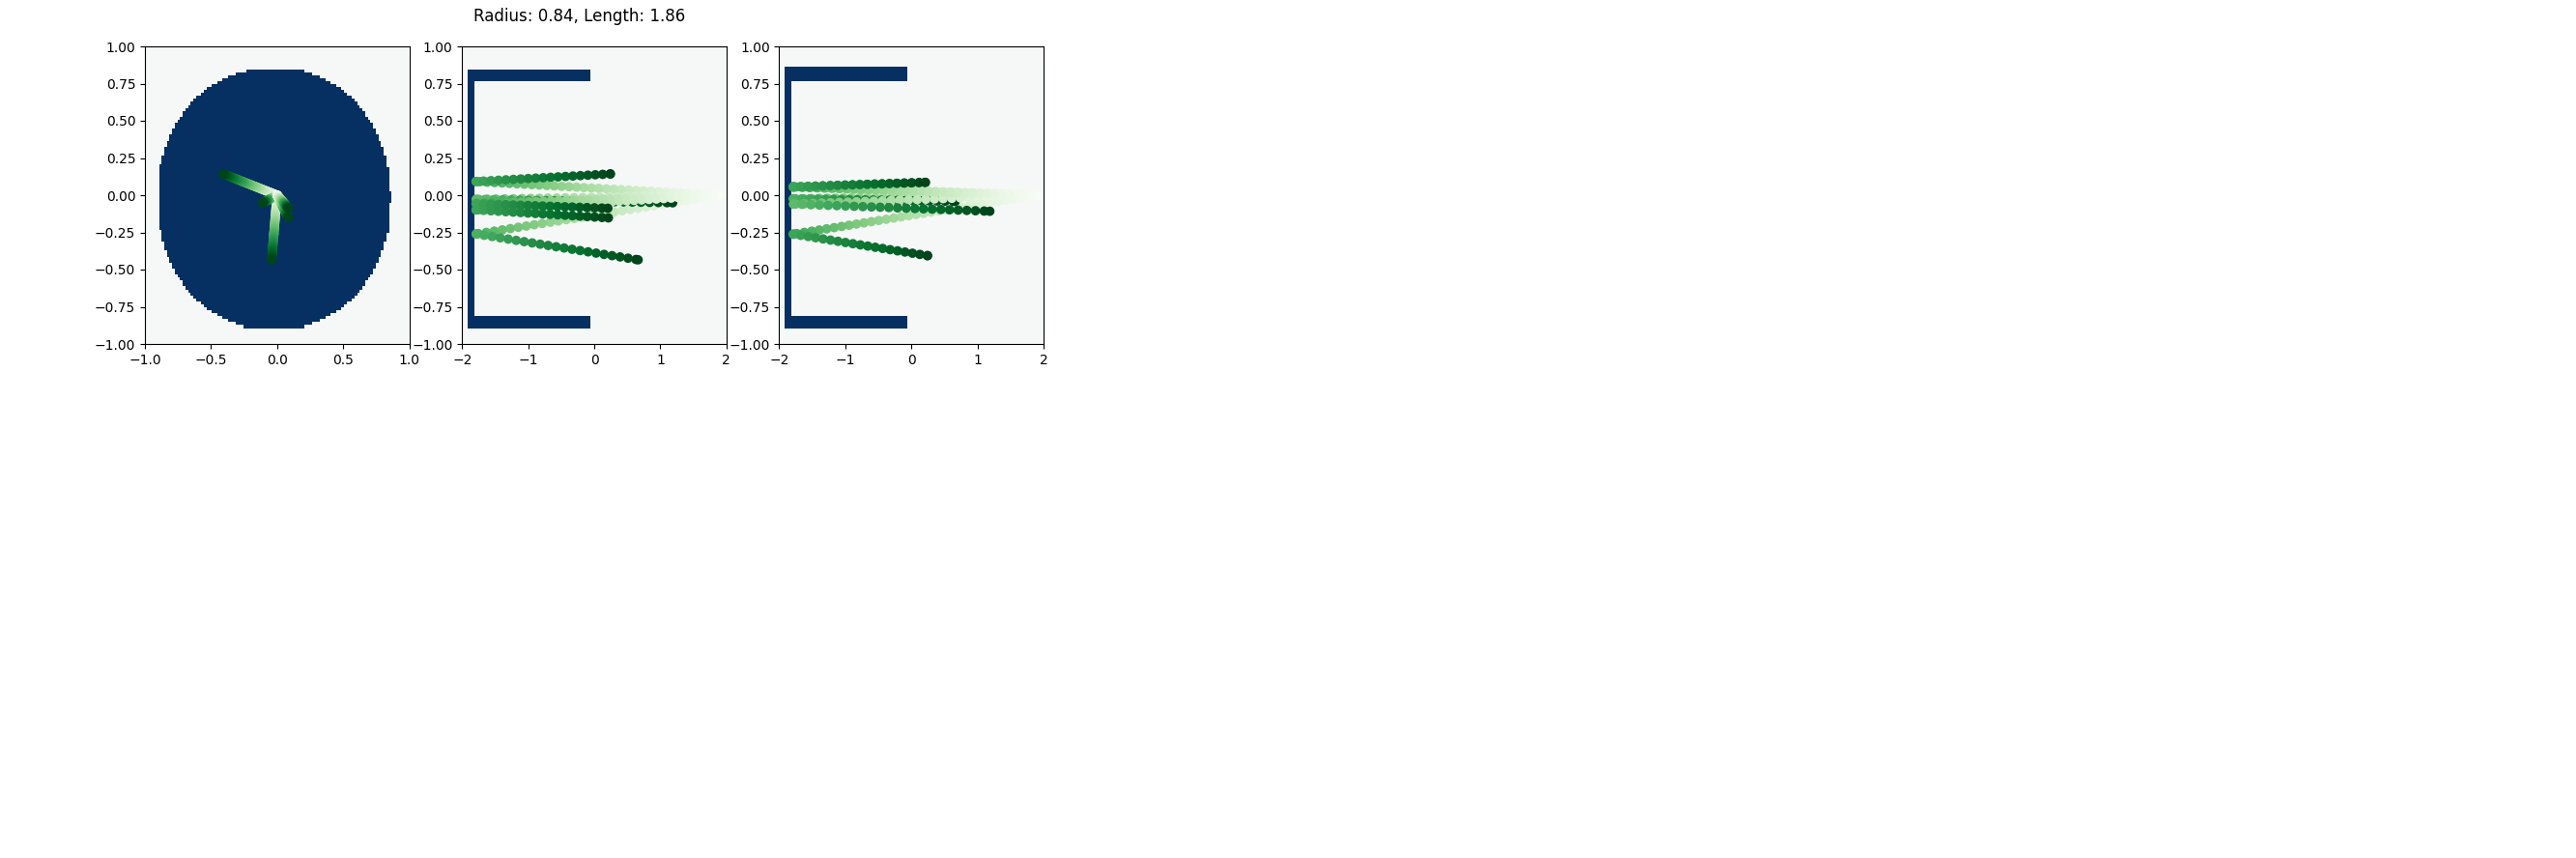

Minimizing.
Radius: 0.84, Length: 1.86 - 5 escapedd

KeyboardInterrupt: 

In [43]:
particles = libem.ChargedParticle3D.generate_particles(NPARTICLES, None,
                                                       particle_opts["mass"][0],
                                                       particle_opts["charge"][0],
                                                       particle_opts["initial_loc"][0],
                                                       particle_opts["initial_v"][0],
                                                       particle_opts["mass"][1],
                                                       particle_opts["charge"][1],
                                                       particle_opts["initial_loc"][1],
                                                       particle_opts["initial_v"][1],
                                                       particle_opts["bounce_coef"])

min_vx = min([abs(p.initial_velocity[0]) for p in particles])
TIME = 4 / min_vx

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.show()
video = VideoMaker(fig, axes)

print("Minimizing.")

def count_escaped(x):
    radius = x[0]
    length = x[1]
    sim = generate_cup_space(radius, length, THICKNESS, SCALE)
    
    escaped = []
    for p in particles:
        p.sim = sim
        p.compute_motion((0, TIME))
        if p.position[0,-1] > -1.9 + length or np.linalg.norm(p.position[1:,-1]) > radius:
            escaped.append(p)
            
    sim.V = sim.boundary_mask
    
    video.new_frame()
    fig.suptitle("Radius: " + str(round(radius, 2)) + ", Length: " + str(round(length, 2)))
    for i, ax in enumerate(axes):
        if i == 0:
            ax.set_xlim((-1, 1))
        else:
            ax.set_xlim((-2, 2))
        ax.set_ylim((-1, 1))
        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=(-1.9 if i == 0 else 0))
        Visualizations.colormesh_2d(sim2d, color_norm=1, graph_ax=ax)
        for p in escaped:
            Visualizations.trajectory_2d(p.time, p.position, axis=i, graph_ax=ax)
    video.draw_frame()
    
    print("\rRadius: {:.2f}, Length: {:.2f} - {} escaped".format(radius, length, len(escaped)), end="")
    
    return len(escaped)

res = differential_evolution(count_escaped, bounds=[(0.05, 1), (0.05, 2)])
print()
print("Minimial Radius: {:.2f}, Length: {:.2f}".format(*res.x))